# Imports

In [70]:
import pandas as pd
import numpy as np
import os,  sys
import datetime as dt

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.ticker as mtick
import matplotlib.dates as mdates

from mpl_toolkits import mplot3d

sys.path.append('/Users/benjaminwong/JupyterNotebooks/masters_pfti/notebooks/python/')

from hetanalysis import HetAnalysis
from clean import PCBCCleaner, DrawPointAssayCleaner
import plotter

output_dir = "../outputs/het_analysis_wrt_time_desensitized_compare_dp_pcbc/"
SAVE = True

plt.rcParams.update(
    {
        'font.size': 18
    }
)

# %matplotlib widget

# Data Input and Cleaning

In [8]:
pcbc_df = PCBCCleaner.get_processed_data()
assay_df = DrawPointAssayCleaner.get_processed_data()

# Group and Output

## Grouping

In [9]:
ids = list(pcbc_df['dhid'].unique())
elements = [
    'CU',
    'AU'
]

### PCBC

In [10]:
pcbc_igs, pcbc_timeslices = {}, {}

for id in ids:
    dp_timeslices = {} 

    filtered_df = pcbc_df.query('dhid == @id').dropna(subset=elements).reset_index(drop=True)

    indices = filtered_df.index.to_list()

    dp_ig = {} # instantaneous grade
    for index in indices:
        date = filtered_df.iloc[index]['date']
        dp_timeslices[date] = {}
        
        for element in elements:
            if element not in dp_ig:
                dp_ig[element] = []
            
            dp_ig[element].append(filtered_df[element].loc[index])
            
            dp_timeslices[date][element] = HetAnalysis(
                f'{id}_{element}_{date}', 
                filtered_df['weight'].loc[:index], 
                filtered_df[element].loc[:index]
                )
    
    pcbc_timeslices[id] = dp_timeslices
    pcbc_igs[id] = dp_ig

### DP Assay

In [11]:
assay_igs, assay_timeslices = {}, {}

for id in ids:
    dp_timeslices = {} 

    filtered_df = assay_df.query('dhid == @id').dropna(subset=elements).reset_index(drop=True)

    indices = filtered_df.index.to_list()

    dp_ig = {} # instantaneous grade
    for index in indices:
        date = filtered_df.iloc[index]['date']
        dp_timeslices[date] = {}
        
        for element in elements:
            if element not in dp_ig:
                dp_ig[element] = []
            
            dp_ig[element].append(filtered_df[element].loc[index])
            
            dp_timeslices[date][element] = HetAnalysis(
                f'{id}_{element}_{date}', 
                filtered_df['weight'].loc[:index], 
                filtered_df[element].loc[:index]
                )
    
    assay_timeslices[id] = dp_timeslices
    assay_igs[id] = dp_ig

## Output

### Individual Graphs

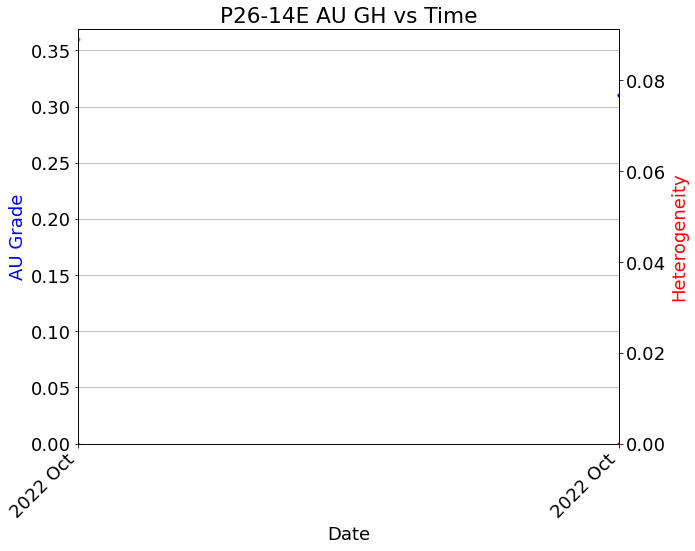

In [29]:
if SAVE:
    fig = plt.figure()
    fig.set_size_inches(10, 8)
    
    for id in ids:
        save_loc = output_dir + f'{id}/'
        if not os.path.exists(save_loc):
            os.makedirs(save_loc)
            
        pcbc_timeslice = pcbc_timeslices[id]
        assay_timeslice = assay_timeslices[id]
        
        for element in elements:
            pcbc_d, pcbc_h = [], []
            for date, timeslice in pcbc_timeslice.items():
                pcbc_d.append(date)
                pcbc_h.append(timeslice[element].get_heterogeneity())
                
            assay_d, assay_h = [], []
            for date, timeslice in assay_timeslice.items():
                assay_d.append(date)
                assay_h.append(timeslice[element].get_heterogeneity())
                
            fig.clear()
            
            ax = fig.add_subplot()
            sec_ax = ax.twinx()

            sec_ax.scatter(assay_d, assay_h, c='red', s=10)
            sec_ax.plot(assay_d, assay_h, c='red', ls='-')
            
            sec_ax.scatter(pcbc_d, pcbc_h, alpha=0.4, c='red', s=10)
            sec_ax.plot(pcbc_d, pcbc_h, alpha=0.2, c='red', ls='-')
            
            sec_ax.set_ylim(0)
            sec_ax.set_ylabel('Heterogeneity', c='red')

            ax.set_xlim(min(min(pcbc_d), min(assay_d)), max(max(pcbc_d), min(assay_d)))
            ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1, 7)))
            ax.xaxis.set_minor_locator(mdates.MonthLocator())
            ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y %b'))
            ax.set_xlabel('Date')

            for label in ax.get_xticklabels(which='major'):
                label.set(rotation=45, horizontalalignment='right')
            
            pcbc_ig = pcbc_igs[id][element]
            assay_ig = assay_igs[id][element]

            ax.scatter(assay_d, assay_ig, c='blue', s=10)
            ax.plot(assay_d, assay_ig, c='blue', ls='-')
            
            ax.scatter(pcbc_d, pcbc_ig, alpha=0.4, c='blue', s=10)
            ax.plot(pcbc_d, pcbc_ig, alpha=0.2, c='blue', ls='-')

            ax.set_ylim(0)
            ax.set_ylabel(f'{element} Grade', c='blue')

            ax.set_title(f'{id} {element} GH vs Time')
            
            ax.grid()

            fig.tight_layout()
            fig.savefig(save_loc + f'{id}_{element}.svg', format='svg')

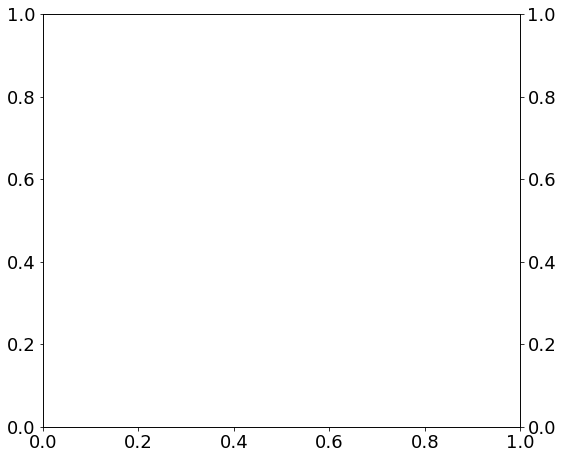

In [72]:
if SAVE:
    fig = plt.figure()
    fig.set_size_inches(10, 8)
    
    for id in ids:
        save_loc = output_dir + f'{id}/'
        if not os.path.exists(save_loc):
            os.makedirs(save_loc)
            
        pcbc_timeslice = pcbc_timeslices[id]
        assay_timeslice = assay_timeslices[id]
        
        for element in elements:
            pcbc_d, pcbc_h = [], []
            for date, timeslice in pcbc_timeslice.items():
                pcbc_d.append(date)
                pcbc_h.append(timeslice[element].get_heterogeneity())
                
            assay_d, assay_h = [], []
            for date, timeslice in assay_timeslice.items():
                assay_d.append(date)
                assay_h.append(timeslice[element].get_heterogeneity())
                
            fig.clear()
            ax = fig.add_subplot()
            sec_ax = ax.twinx()

            pcbc_timeslice = pcbc_timeslices[id]
            assay_timeslice = assay_timeslices[id]

            pcbc_d, pcbc_h = [], []
            for date, timeslice in pcbc_timeslice.items():
                pcbc_d.append(date)
                pcbc_h.append(timeslice[element].get_heterogeneity())
                
            assay_d, assay_h = [], []
            for date, timeslice in assay_timeslice.items():
                assay_d.append(date)
                assay_h.append(timeslice[element].get_heterogeneity())
                
            # Get a list of dates to perform interpolation on
            earliest_common_date = max(pcbc_d[0], assay_d[0])
            latest_common_date = min(pcbc_d[-1], assay_d[-1])
            dates = pcbc_d + assay_d
            dates.sort()

            common_dates = [d for d in dates if d >= earliest_common_date and d <= latest_common_date]
            if len(common_dates) == 0:
                break

            sec_ax.scatter(assay_d, assay_h, c='red', s=10)
            sec_ax.plot(assay_d, assay_h, c='red', ls='-')

            sec_ax.scatter(pcbc_d, pcbc_h, alpha=0.4, c='red', s=10)
            sec_ax.plot(pcbc_d, pcbc_h, alpha=0.2, c='red', ls='-')

            sec_ax.set_ylim(0)
            sec_ax.set_ylabel('Heterogeneity', c='red')

            ax.set_xlim(min(min(pcbc_d), min(assay_d)), max(max(pcbc_d), min(assay_d)))
            ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1, 7)))
            ax.xaxis.set_minor_locator(mdates.MonthLocator())
            ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y %b'))
            ax.set_xlabel('Date')

            for label in ax.get_xticklabels(which='major'):
                label.set(rotation=45, horizontalalignment='right')

            pcbc_ig = pcbc_igs[id][element]
            assay_ig = assay_igs[id][element]

            epoch = common_dates[0]

            def to_float(d):
                return (d - epoch).total_seconds()

            delta_grades = [
                np.interp(
                    to_float(date),
                    [to_float(d) for d in assay_d], 
                    assay_ig
                ) - np.interp(
                    to_float(date),
                    [to_float(d) for d in pcbc_d], 
                    pcbc_ig
                ) for date in common_dates
            ]

            ax.scatter(common_dates, delta_grades, c='blue', s=10)
            ax.plot(common_dates, delta_grades, c='blue', ls='-')

            ax.set_ylabel(f'{element} Grade $\Delta$ (Assay - PCBC)', c='blue')

            ax.set_title(f'{id} {element} GH vs Time')

            ax.grid()

            fig.tight_layout()
            fig.savefig(save_loc + f'{id}_{element}.svg', format='svg')

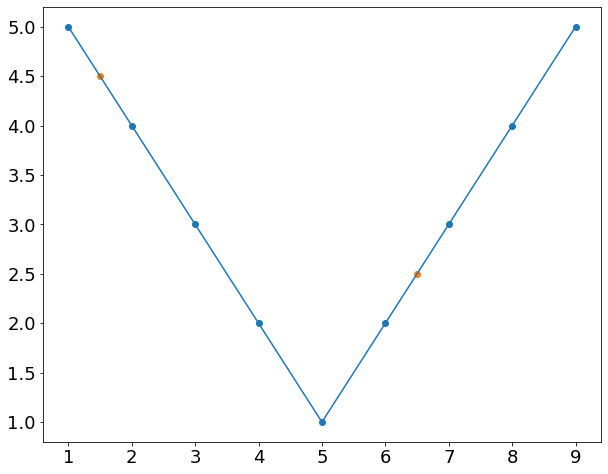

In [5]:
xs = [1, 2, 3, 4, 5, 6, 7, 8, 9]
ys = [5, 4, 3, 2, 1, 2, 3, 4, 5]

extra_xs = [1.5, 6.5]

fig = plt.figure()
fig.set_size_inches(10, 8)
ax = fig.add_subplot()

ax.plot(xs, ys)
ax.scatter(xs, ys)
ax.scatter(extra_xs, [np.interp(x, xs, ys) for x in extra_xs])

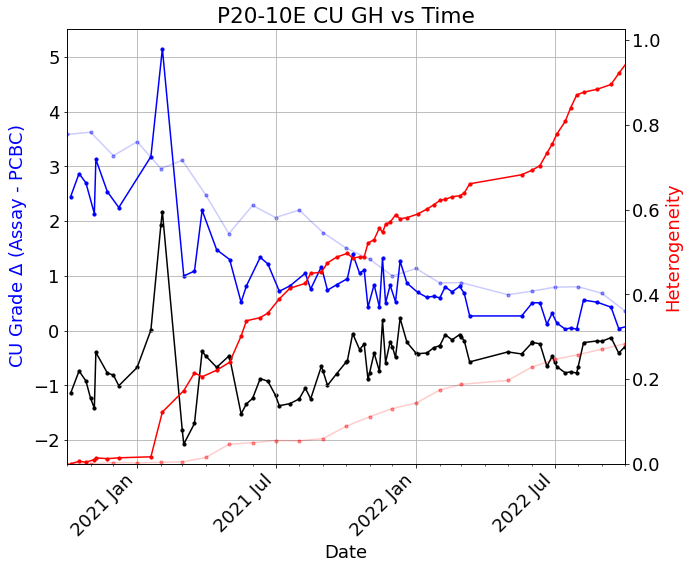

In [69]:
element = 'CU'
id = 'P20-10E'

fig = plt.figure()
fig.set_size_inches(10, 8)

fig.clear()
ax = fig.add_subplot()
sec_ax = ax.twinx()

pcbc_timeslice = pcbc_timeslices[id]
assay_timeslice = assay_timeslices[id]

pcbc_d, pcbc_h = [], []
for date, timeslice in pcbc_timeslice.items():
    pcbc_d.append(date)
    pcbc_h.append(timeslice[element].get_heterogeneity())
    
assay_d, assay_h = [], []
for date, timeslice in assay_timeslice.items():
    assay_d.append(date)
    assay_h.append(timeslice[element].get_heterogeneity())
    
# Get a list of dates to perform interpolation on
earliest_common_date = max(pcbc_d[0], assay_d[0])
latest_common_date = min(pcbc_d[-1], assay_d[-1])
dates = pcbc_d + assay_d
dates.sort()

common_dates = [d for d in dates if d >= earliest_common_date and d <= latest_common_date]

sec_ax.scatter(assay_d, assay_h, c='red', s=10)
sec_ax.plot(assay_d, assay_h, c='red', ls='-')

sec_ax.scatter(pcbc_d, pcbc_h, alpha=0.4, c='red', s=10)
sec_ax.plot(pcbc_d, pcbc_h, alpha=0.2, c='red', ls='-')

sec_ax.set_ylim(0)
sec_ax.set_ylabel('Heterogeneity', c='red')

ax.set_xlim(min(min(pcbc_d), min(assay_d)), max(max(pcbc_d), min(assay_d)))
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1, 7)))
ax.xaxis.set_minor_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y %b'))
ax.set_xlabel('Date')

for label in ax.get_xticklabels(which='major'):
    label.set(rotation=45, horizontalalignment='right')

pcbc_ig = pcbc_igs[id][element]
assay_ig = assay_igs[id][element]

epoch = common_dates[0]

def to_float(d):
    return (d - epoch).total_seconds()

delta_grades = [
    np.interp(
        to_float(date),
        [to_float(d) for d in assay_d], 
        assay_ig
    ) - np.interp(
        to_float(date),
        [to_float(d) for d in pcbc_d], 
        pcbc_ig
    ) for date in common_dates
]

ax.scatter(common_dates, delta_grades, c='black', s=10)
ax.plot(common_dates, delta_grades, c='black', ls='-')

# ax.scatter(assay_d, assay_ig, c='blue', s=10)
# ax.plot(assay_d, assay_ig, c='blue', ls='-')

# ax.scatter(pcbc_d, pcbc_ig, alpha=0.4, c='blue', s=10)
# ax.plot(pcbc_d, pcbc_ig, alpha=0.2, c='blue', ls='-')

ax.set_ylabel(f'{element} Grade $\Delta$ (Assay - PCBC)', c='blue')

ax.set_title(f'{id} {element} GH vs Time')

ax.grid()


In [38]:
epoch = common_dates[0]
[np.interp(to_float(d), 
    [(d - epoch).total_seconds() for d in pcbc_d], 
    pcbc_ig) for d in common_dates
 ]

[3.59063458442688,
 3.605342149734497,
 3.617375612258911,
 3.6253979206085205,
 3.554053624471029,
 3.525515906016032,
 3.3114830176035563,
 3.1973321437835693,
 3.254771655605685,
 3.451707124710083,
 3.167534866640645,
 2.962299346923828,
 2.97296210697719,
 3.1115779876708984,
 3.070515755684145,
 2.783080131776871,
 2.577768971843104,
 2.4751133918762207,
 2.1476544618606566,
 1.7734156847000122,
 1.7900197813587804,
 2.0390812312403033,
 2.1553099078516804,
 2.288142681121826,
 2.2147163550059,
 2.141290028889974,
 2.067863702774048,
 2.089727109478366,
 2.150944648250457,
 2.2034168243408203,
 2.0976625565559632,
 2.0051275722442137,
 1.8200576036207137,
 1.7936190366744995,
 1.7374911785125733,
 1.6252354621887206,
 1.5129797458648682,
 1.4997171663468885,
 1.4532981380339591,
 1.39361653020305,
 1.3538287916491107,
 1.3206723428541614,
 1.3074097633361816,
 1.2457669496536254,
 1.1738503336906434,
 1.1327551245689391,
 1.091659915447235,
 1.0300171017646789,
 0.999195694923400

(array([ 1.,  1.,  1.,  1.,  2.,  6.,  2.,  3.,  5., 13.,  7., 14.,  8.,
        11.,  4.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  1.,  1.]),
 array([-2.07051576, -1.92893063, -1.78734551, -1.64576039, -1.50417527,
        -1.36259015, -1.22100503, -1.0794199 , -0.93783478, -0.79624966,
        -0.65466454, -0.51307942, -0.3714943 , -0.22990917, -0.08832405,
         0.05326107,  0.19484619,  0.33643131,  0.47801643,  0.61960156,
         0.76118668,  0.9027718 ,  1.04435692,  1.18594204,  1.32752716,
         1.46911228,  1.61069741,  1.75228253,  1.89386765,  2.03545277,
         2.17703789]),
 <BarContainer object of 30 artists>)

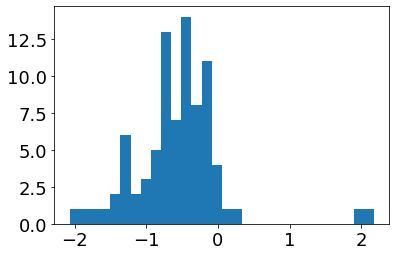

In [52]:
plt.hist(delta_grades, 30)

In [56]:
pd.Series(delta_grades).describe()

count    83.000000
mean     -0.565174
std       0.616095
min      -2.070516
25%      -0.843358
50%      -0.549717
75%      -0.257742
max       2.177038
dtype: float64

In [60]:
from datetime import datetime, timedelta
from dateutil.relativedelta import *
from dateutil import rrule

def filter_by_date(df, date):
    return df[(df['date'] >= date) & (df['date'] < (date + relativedelta(months=1)))]

In [68]:
# Find the months in the datasets
earliest = min(common_dates)
latest = max(common_dates)

datetime.date(earliest)
for dt in rrule.rrule(rrule.MONTHLY, dtstart=earliest, until=latest):
    print(datetime(dt.year, dt.month, day=1))

2020-10-01 00:00:00
2020-11-01 00:00:00
2020-12-01 00:00:00
2021-01-01 00:00:00
2021-02-01 00:00:00
2021-03-01 00:00:00
2021-04-01 00:00:00
2021-05-01 00:00:00
2021-06-01 00:00:00
2021-07-01 00:00:00
2021-08-01 00:00:00
2021-09-01 00:00:00
2021-10-01 00:00:00
2021-11-01 00:00:00
2021-12-01 00:00:00
2022-01-01 00:00:00
2022-02-01 00:00:00
2022-03-01 00:00:00
2022-04-01 00:00:00
2022-05-01 00:00:00
2022-06-01 00:00:00
2022-07-01 00:00:00
2022-08-01 00:00:00
2022-09-01 00:00:00


In [ ]:
elements = [
    'CU',
    'AU'
]

def group_by_month(df):
    return_dict = {}
    
    earliest = df['date'].dt.date.min()
    latest = df['date'].dt.date.max()
    for dt in rrule.rrule(rrule.MONTHLY, dtstart=earliest, until=latest):
        filtered_df = filter_by_date(df, datetime(dt.year, dt.month, day=1))
        
        return_dict[dt] = {}
        date = f'{dt.year}_{dt.month}'
        for element in elements:
            try:
                return_dict[dt][element] = HetAnalysis(f'{date}_{element}', filtered_df['weight'], filtered_df[element])
            except:
                print(f'Invalid data for {date}_{element}')
                
    return return_dict